In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf
import os
import pickle
import re
from tensorflow.python.ops import math_ops
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

In [2]:


def _unzip(save_path, _, database_name, data_path):
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
        

In [9]:
data_dir = './'
download_extract('ml-1m', data_dir)

Found ml-1m Data


In [18]:
'''
users_title = ['UserID','Gender','Age','OccupationID','Zip=code']
usersd = pd.read_table('./ml-1m/users.dat',sep='::',header=None,names=users_title,engine='python')
users = usersd.filter(regex='UserID|Gender|Age|OccupationID')
print(users.head())
#print(usersd.head())
users_orig = users.values
print(users_orig)
print(set(users['Age']))
'''

   UserID Gender  Age  OccupationID Zip=code
0       1      F    1            10    48067
1       2      M   56            16    70072
2       3      M   25            15    55117
3       4      M   45             7    02460
4       5      M   25            20    55455
[[1 'F' 1 10]
 [2 'M' 56 16]
 [3 'M' 25 15]
 ..., 
 [6038 'F' 56 1]
 [6039 'F' 45 0]
 [6040 'M' 25 6]]
{1, 35, 45, 50, 18, 56, 25}


In [56]:
'''
movies_title = ['MovieID','Title','Genres']
movies = pd.read_table('./ml-1m/movies.dat',sep='::',header=None,names=movies_title,engine='python')
print(movies.head())
movies_orig = movies.values
pattern = re.compile(r'^(.*)\((\d+)\)$')
title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)
#电影title转化为数字字典
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)
#print(len(title_set))
title_set.add('<PAD>')
title2int = {val:ii for ii,val in enumerate(title_set)}
#print(title2int)
    #title转成等长数字列表15
    #将电影Title转成等长数字列表，长度是15
title_count = 15
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
movies['Title'] = movies['Title'].map(title_map)
print(len(movies['Title'][8]))    
'''

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
15


In [8]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
print(ratings.head())

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [66]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [67]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [70]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [81]:
movies.head()
#movies.values

,MovieID,Title,Genres
0,1,"[803, 3664, 4038, 4038, 4038, 4038, 4038, 4038...","[15, 11, 1, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
1,2,"[576, 4038, 4038, 4038, 4038, 4038, 4038, 4038...","[0, 11, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
2,3,"[4787, 1692, 2235, 4038, 4038, 4038, 4038, 403...","[1, 2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,..."
3,4,"[4681, 3109, 2038, 4038, 4038, 4038, 4038, 403...","[1, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,..."
4,5,"[1267, 3136, 2712, 4498, 3276, 965, 4038, 4038...","[1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12..."


In [3]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))


In [6]:
features;

In [7]:
import tensorflow as tf
import os 
import pickle
def save_params(params):
    pickle.dump(params,open('params.p', 'wb'))
def load_params():
    return pickle.load(open('params.p', mode='rb'))

In [8]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21


#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [9]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [10]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [12]:
#构建神经网络

In [13]:
#定义user的嵌入矩阵

In [14]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [15]:
#将suer的嵌入矩阵一起全连接生成user特征

In [16]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [17]:
#定义movie ID的嵌入矩阵

In [18]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [19]:
#对电影类型多个嵌入向量做加和

In [20]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [21]:
#movie title的文本卷积网络实现

In [22]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        #在最后一维增加维度
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            #卷积层的参数：前两个维度是filter的尺寸，第三个是当前层的深度，第四个filter的深度
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            #偏置参数，filter的深度
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            #第二个参数过滤器尺寸，第三个参数为步长
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        #在第三维上做连接
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [23]:
#将movie的各个层一起做全连接

In [24]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [38]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
        inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
        inference = tf.layers.dense(inference_layer, 1,
                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
        #inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
    #train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

In [39]:
inference;

In [40]:
#取的batch

In [41]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [42]:
#训练网络

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    '''
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    '''
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, _ = sess.run([global_step, loss,train_op], feed)  #cost
            losses['train'].append(train_loss)
            #train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss = sess.run([global_step, loss], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            #inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


2018-01-15T19:34:30.348988: Epoch   0 Batch    0/3125   train_loss = 14.436
2018-01-15T19:34:31.492054: Epoch   0 Batch   20/3125   train_loss = 11.001
2018-01-15T19:34:32.419107: Epoch   0 Batch   40/3125   train_loss = 7.371
2018-01-15T19:34:33.315158: Epoch   0 Batch   60/3125   train_loss = 4.670
2018-01-15T19:34:34.178207: Epoch   0 Batch   80/3125   train_loss = 3.093
2018-01-15T19:34:35.236268: Epoch   0 Batch  100/3125   train_loss = 2.145
2018-01-15T19:34:36.517341: Epoch   0 Batch  120/3125   train_loss = 1.611
2018-01-15T19:34:37.518398: Epoch   0 Batch  140/3125   train_loss = 1.373
2018-01-15T19:34:38.625462: Epoch   0 Batch  160/3125   train_loss = 1.186
2018-01-15T19:34:39.712524: Epoch   0 Batch  180/3125   train_loss = 1.242
2018-01-15T19:34:40.782585: Epoch   0 Batch  200/3125   train_loss = 1.478
2018-01-15T19:34:41.653635: Epoch   0 Batch  220/3125   train_loss = 1.341
2018-01-15T19:34:42.546686: Epoch   0 Batch  240/3125   train_loss = 1.277
2018-01-15T19:34:43.447

2018-01-15T19:36:19.070207: Epoch   0 Batch 2200/3125   train_loss = 1.040
2018-01-15T19:36:19.966258: Epoch   0 Batch 2220/3125   train_loss = 1.086
2018-01-15T19:36:21.123324: Epoch   0 Batch 2240/3125   train_loss = 0.981
2018-01-15T19:36:22.206386: Epoch   0 Batch 2260/3125   train_loss = 1.061
2018-01-15T19:36:23.215444: Epoch   0 Batch 2280/3125   train_loss = 1.119
2018-01-15T19:36:24.370510: Epoch   0 Batch 2300/3125   train_loss = 1.130
2018-01-15T19:36:25.329565: Epoch   0 Batch 2320/3125   train_loss = 1.216
2018-01-15T19:36:26.357624: Epoch   0 Batch 2340/3125   train_loss = 1.111
2018-01-15T19:36:27.360681: Epoch   0 Batch 2360/3125   train_loss = 1.063
2018-01-15T19:36:28.288734: Epoch   0 Batch 2380/3125   train_loss = 1.102
2018-01-15T19:36:29.279791: Epoch   0 Batch 2400/3125   train_loss = 1.167
2018-01-15T19:36:30.189843: Epoch   0 Batch 2420/3125   train_loss = 1.055
2018-01-15T19:36:31.177899: Epoch   0 Batch 2440/3125   train_loss = 1.141
2018-01-15T19:36:32.20595

2018-01-15T19:37:45.612157: Epoch   1 Batch  495/3125   train_loss = 0.985
2018-01-15T19:37:46.532209: Epoch   1 Batch  515/3125   train_loss = 1.029
2018-01-15T19:37:47.461263: Epoch   1 Batch  535/3125   train_loss = 1.085
2018-01-15T19:37:48.370315: Epoch   1 Batch  555/3125   train_loss = 1.178
2018-01-15T19:37:49.324369: Epoch   1 Batch  575/3125   train_loss = 1.083
2018-01-15T19:37:50.172418: Epoch   1 Batch  595/3125   train_loss = 1.188
2018-01-15T19:37:51.123472: Epoch   1 Batch  615/3125   train_loss = 1.052
2018-01-15T19:37:52.051525: Epoch   1 Batch  635/3125   train_loss = 1.059
2018-01-15T19:37:53.152588: Epoch   1 Batch  655/3125   train_loss = 0.889
2018-01-15T19:37:54.411660: Epoch   1 Batch  675/3125   train_loss = 0.841
2018-01-15T19:37:55.393716: Epoch   1 Batch  695/3125   train_loss = 0.969
2018-01-15T19:37:56.382773: Epoch   1 Batch  715/3125   train_loss = 1.041
2018-01-15T19:37:57.418832: Epoch   1 Batch  735/3125   train_loss = 0.930
2018-01-15T19:37:58.36188

2018-01-15T19:39:30.844176: Epoch   1 Batch 2695/3125   train_loss = 0.963
2018-01-15T19:39:31.719226: Epoch   1 Batch 2715/3125   train_loss = 0.954
2018-01-15T19:39:32.608277: Epoch   1 Batch 2735/3125   train_loss = 0.847
2018-01-15T19:39:33.594333: Epoch   1 Batch 2755/3125   train_loss = 1.075
2018-01-15T19:39:34.480384: Epoch   1 Batch 2775/3125   train_loss = 0.985
2018-01-15T19:39:35.496442: Epoch   1 Batch 2795/3125   train_loss = 1.020
2018-01-15T19:39:36.618506: Epoch   1 Batch 2815/3125   train_loss = 0.920
2018-01-15T19:39:37.618563: Epoch   1 Batch 2835/3125   train_loss = 1.028
2018-01-15T19:39:38.555617: Epoch   1 Batch 2855/3125   train_loss = 0.995
2018-01-15T19:39:39.458668: Epoch   1 Batch 2875/3125   train_loss = 0.937
2018-01-15T19:39:40.343719: Epoch   1 Batch 2895/3125   train_loss = 0.942
2018-01-15T19:39:41.221769: Epoch   1 Batch 2915/3125   train_loss = 0.885
2018-01-15T19:39:42.133821: Epoch   1 Batch 2935/3125   train_loss = 1.086
2018-01-15T19:39:43.05587

2018-01-15T19:41:03.236460: Epoch   2 Batch 1010/3125   train_loss = 1.077
2018-01-15T19:41:04.417528: Epoch   2 Batch 1030/3125   train_loss = 0.894
2018-01-15T19:41:05.694601: Epoch   2 Batch 1050/3125   train_loss = 0.884
2018-01-15T19:41:07.132683: Epoch   2 Batch 1070/3125   train_loss = 0.884
2018-01-15T19:41:08.216745: Epoch   2 Batch 1090/3125   train_loss = 1.021
2018-01-15T19:41:09.209802: Epoch   2 Batch 1110/3125   train_loss = 1.020
2018-01-15T19:41:10.228860: Epoch   2 Batch 1130/3125   train_loss = 0.905
2018-01-15T19:41:11.257919: Epoch   2 Batch 1150/3125   train_loss = 0.957
2018-01-15T19:41:12.303979: Epoch   2 Batch 1170/3125   train_loss = 0.954
2018-01-15T19:41:13.330038: Epoch   2 Batch 1190/3125   train_loss = 0.963
2018-01-15T19:41:14.333095: Epoch   2 Batch 1210/3125   train_loss = 0.831
2018-01-15T19:41:15.587167: Epoch   2 Batch 1230/3125   train_loss = 0.786
2018-01-15T19:41:16.655228: Epoch   2 Batch 1250/3125   train_loss = 0.963
2018-01-15T19:41:17.78329

2018-01-15T19:42:48.989509: Epoch   2 Batch   98/781   test_loss = 0.896
2018-01-15T19:42:49.350530: Epoch   2 Batch  118/781   test_loss = 0.852
2018-01-15T19:42:49.743552: Epoch   2 Batch  138/781   test_loss = 1.010
2018-01-15T19:42:50.155576: Epoch   2 Batch  158/781   test_loss = 0.814
2018-01-15T19:42:50.529597: Epoch   2 Batch  178/781   test_loss = 0.841
2018-01-15T19:42:50.996624: Epoch   2 Batch  198/781   test_loss = 0.893
2018-01-15T19:42:51.459650: Epoch   2 Batch  218/781   test_loss = 0.970
2018-01-15T19:42:51.901676: Epoch   2 Batch  238/781   test_loss = 0.896
2018-01-15T19:42:52.329700: Epoch   2 Batch  258/781   test_loss = 0.996
2018-01-15T19:42:52.708722: Epoch   2 Batch  278/781   test_loss = 1.014
2018-01-15T19:42:53.077743: Epoch   2 Batch  298/781   test_loss = 0.851
2018-01-15T19:42:53.483766: Epoch   2 Batch  318/781   test_loss = 0.867
2018-01-15T19:42:53.884789: Epoch   2 Batch  338/781   test_loss = 0.897
2018-01-15T19:42:54.286812: Epoch   2 Batch  358/78

2018-01-15T19:44:33.095464: Epoch   3 Batch 1525/3125   train_loss = 0.792
2018-01-15T19:44:34.561547: Epoch   3 Batch 1545/3125   train_loss = 0.860
2018-01-15T19:44:36.400653: Epoch   3 Batch 1565/3125   train_loss = 0.961
2018-01-15T19:44:37.891738: Epoch   3 Batch 1585/3125   train_loss = 0.797
2018-01-15T19:44:39.052804: Epoch   3 Batch 1605/3125   train_loss = 0.866
2018-01-15T19:44:40.137866: Epoch   3 Batch 1625/3125   train_loss = 0.940
2018-01-15T19:44:41.244930: Epoch   3 Batch 1645/3125   train_loss = 0.937
2018-01-15T19:44:42.318991: Epoch   3 Batch 1665/3125   train_loss = 0.901
2018-01-15T19:44:43.377052: Epoch   3 Batch 1685/3125   train_loss = 0.947
2018-01-15T19:44:44.763131: Epoch   3 Batch 1705/3125   train_loss = 0.909
2018-01-15T19:44:46.293218: Epoch   3 Batch 1725/3125   train_loss = 0.833
2018-01-15T19:44:47.590293: Epoch   3 Batch 1745/3125   train_loss = 0.754
2018-01-15T19:44:48.689355: Epoch   3 Batch 1765/3125   train_loss = 0.840
2018-01-15T19:44:49.71541

2018-01-15T19:46:18.535494: Epoch   3 Batch  637/781   test_loss = 0.815
2018-01-15T19:46:18.888515: Epoch   3 Batch  657/781   test_loss = 0.988
2018-01-15T19:46:19.274537: Epoch   3 Batch  677/781   test_loss = 0.912
2018-01-15T19:46:19.676560: Epoch   3 Batch  697/781   test_loss = 0.902
2018-01-15T19:46:20.034580: Epoch   3 Batch  717/781   test_loss = 0.822
2018-01-15T19:46:20.406601: Epoch   3 Batch  737/781   test_loss = 0.754
2018-01-15T19:46:20.803624: Epoch   3 Batch  757/781   test_loss = 1.002
2018-01-15T19:46:21.170645: Epoch   3 Batch  777/781   test_loss = 0.909
2018-01-15T19:46:21.940689: Epoch   4 Batch    0/3125   train_loss = 0.936
2018-01-15T19:46:22.827740: Epoch   4 Batch   20/3125   train_loss = 0.842
2018-01-15T19:46:23.747792: Epoch   4 Batch   40/3125   train_loss = 0.857
2018-01-15T19:46:24.796852: Epoch   4 Batch   60/3125   train_loss = 0.756
2018-01-15T19:46:25.881915: Epoch   4 Batch   80/3125   train_loss = 0.855
2018-01-15T19:46:26.814968: Epoch   4 Bat

2018-01-15T19:48:03.494498: Epoch   4 Batch 2040/3125   train_loss = 0.781
2018-01-15T19:48:04.698567: Epoch   4 Batch 2060/3125   train_loss = 0.806
2018-01-15T19:48:06.232654: Epoch   4 Batch 2080/3125   train_loss = 0.988
2018-01-15T19:48:07.480726: Epoch   4 Batch 2100/3125   train_loss = 0.759
2018-01-15T19:48:08.489783: Epoch   4 Batch 2120/3125   train_loss = 0.778
2018-01-15T19:48:09.497841: Epoch   4 Batch 2140/3125   train_loss = 0.858
2018-01-15T19:48:10.542901: Epoch   4 Batch 2160/3125   train_loss = 0.822
2018-01-15T19:48:11.681966: Epoch   4 Batch 2180/3125   train_loss = 0.894
2018-01-15T19:48:12.808030: Epoch   4 Batch 2200/3125   train_loss = 0.819
2018-01-15T19:48:13.961096: Epoch   4 Batch 2220/3125   train_loss = 0.813
2018-01-15T19:48:15.053159: Epoch   4 Batch 2240/3125   train_loss = 0.856
2018-01-15T19:48:16.236226: Epoch   4 Batch 2260/3125   train_loss = 0.856
2018-01-15T19:48:17.320288: Epoch   4 Batch 2280/3125   train_loss = 0.840
2018-01-15T19:48:18.51935

In [44]:
save_params((save_dir))

load_dir = load_params()

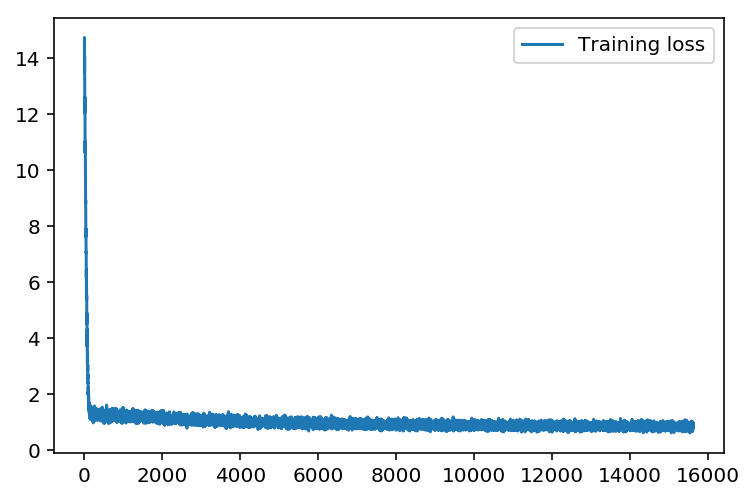

In [45]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

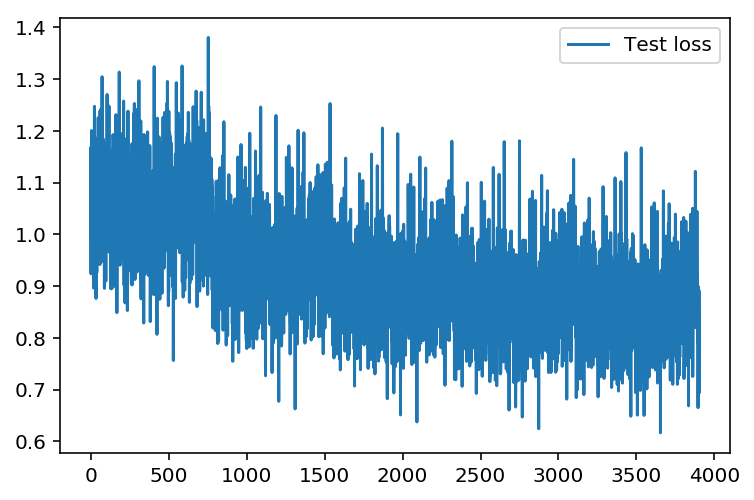

In [46]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [47]:
#获取tensor

In [48]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
    inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    #inference = loaded_graph.get_tensor_by_name("inference/MatMul:0")#
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


In [49]:
#指定用户和电影进行评分

In [50]:
#正向传播，预测评分

In [51]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [73]:
rating_movie(234, 5)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 3.16517735]], dtype=float32)]

In [53]:
rating_movie(1,1)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 4.27231884]], dtype=float32)]

In [54]:
rating_movie(1,661)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 3.56507564]], dtype=float32)]

In [55]:
rating_movie(4490,2526)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 2.69281101]], dtype=float32)]

In [56]:
#生成电影特征矩阵并保存

In [57]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [58]:
#生成用户特征矩阵并保存

In [59]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [62]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [63]:
#开始推荐


In [64]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        #余弦相似度
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        #=.transpose()转置函数
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        #argsort函数返回的是数组值从小到大的索引值
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [65]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
2241
[2310 'Mighty, The (1998)' 'Drama']
802
[812 'Magic Hunter (1994)' 'Drama']
617
[621 'My Favorite Season (1993)' 'Drama']
2990
[3059 'British Intelligence (1940)' 'Drama']
3342
[3411 'Babymother (1998)' 'Drama']


{617, 802, 2241, 2990, 3342}

In [66]:
#推荐你喜欢的电影

In [67]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results


In [68]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
1959
[2028 'Saving Private Ryan (1998)' 'Action|Drama|War']
1178
[1196 'Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Drama|Sci-Fi|War']
1613
[1659 'Hurricane Streets (1998)' 'Drama']
1726
[1784 'As Good As It Gets (1997)' 'Comedy|Drama']
2663
[2732 'Jules and Jim (Jules et Jim) (1961)' 'Drama']


{1178, 1613, 1726, 1959, 2663}

In [74]:
#喜欢这个电影的人还喜欢那些电影

In [75]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [76]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[197 'M' 18 14]
 [238 'F' 50 7]
 [5346 'F' 25 3]
 [5164 'F' 35 17]
 [3257 'M' 25 14]
 [937 'M' 25 15]
 [5630 'M' 35 17]
 [4117 'M' 18 4]
 [4971 'M' 35 7]
 [5591 'M' 18 0]
 [4153 'M' 50 17]
 [2718 'F' 25 4]
 [4262 'F' 35 6]
 [2758 'M' 56 8]
 [2267 'F' 56 13]
 [5427 'M' 35 19]
 [5520 'M' 45 1]
 [148 'M' 50 17]
 [4520 'M' 25 4]
 [4012 'M' 18 4]]
喜欢看这个电影的人还喜欢看：
2752
[2821 'Male and Female (1919)' 'Adventure|Drama']
2881
[2950 'Blue Lagoon, The (1980)' 'Adventure|Drama|Romance']
1688
[1739 '3 Ninjas: High Noon On Mega Mountain (1998)' "Action|Children's"]
2358
[2427 'Thin Red Line, The (1998)' 'Action|Drama|War']
2353
[2422 'Karate Kid III, The (1989)' 'Action|Adventure|Drama']


{1688, 2353, 2358, 2752, 2881}